## Basic RAG Pipeline

**Ingestion, Retrieval, Synthesis**

### Ingestion
Documents -> Chunks -> Embeddings -> Index

1. Set of documents loaded
2. Each document split into set of text chunks using text splitter
3. For each chunk, embedding generated
4. Each chunk with embedding offloaded to an idex which is a view of a storage system

Once data is stored within an index, we then perform **retrieval** against that index.

### Retrieval

Query -> Index -> Top K

* Launch user **query** against **index**
* fetch **top k** most similar chunks to the user query.

### Synthesis

Query and top K (from Retrieval) -> LLM -> Response

* Take relevant k chunks, combine it with user query and put into prompt window of LLM, then get final response.




In [2]:
import utils
import os
from dotenv import load_dotenv, find_dotenv

# Load the .env file
_ = load_dotenv(find_dotenv())

# verify it works
api_key = os.getenv("OPENAI_API_KEY")
print(f"Key loaded: {api_key[:5]}...")

ModuleNotFoundError: These package is required for evaluating feedback using OpenAI:

    trulens-providers-openai

You should be able to install it with pip:

    ```bash
    pip install "trulens-providers-openai>=1.0.0"
    ```

In [ ]:
from llama_index.core import SimpleDirectoryReader
documents = SimpleDirectoryReader(input_files = ['./PEFT_of_ASR.pdf']).load_data() # I'm using my masters thesis here :)

In [ ]:
# see what is in documents

print(type(documents), "\n")
print(len(documents), "\n") # one page of the PDF = one Document object
print(type(documents[0]))
print(documents[0])

<class 'list'> 

12 

<class 'llama_index.core.schema.Document'>
Doc ID: 24ea2995-54c5-4bfc-ad56-2f501cc2eed5
Text: Parameter-Efficient Finetuning of ASR Models for  Maritime Radio
Communications in Ireland  Abstract   The need for manual logging of
critical Very High Frequency (VHF) radio communi- cations by the Irish
Coast Guard ( IRCG) puts an additional cognitive load on watch
officers, compromising their situational awareness. While Automatic
Speech Rec...


## Ingestion

In [ ]:
from llama_index.core import Document

"""
  Merge multiple separate document objects into a single Document object
"""
document = Document(text = "\n\n".join([doc.text for doc in documents]))

In [ ]:
# Index the documents using VectorStoreIndex
from llama_index.core import VectorStoreIndex, Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# define service context object which contains LLM and the embedding model
llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1)

embed_model = HuggingFaceEmbedding(model_name = "BAAI/bge-small-en-v1.5")

Settings.llm = llm
Settings.embed_model = embed_model
index = VectorStoreIndex.from_documents([document],)



c:\Users\sprin\Desktop\Thendral\DeepLearningAI\Building-and-Evaluating-Advaanced-RAG\learn-dlai-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-09 21:57:32,498 - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
c:\Users\sprin\Desktop\Thendral\DeepLearningAI\Building-and-Evaluating-Advaanced-RAG\learn-dlai-env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sprin\AppData\Local\llama_index\llama_index\Cache\models--BAAI--bge-small-en-v1.5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environme

# Retrieval & Synthesis

In [ ]:
# define the query engine that allows us to do retrieval and synthesis against this data

query_engine = index.as_query_engine()

In [ ]:
response = query_engine.query(
    "What are the general-purpose ASR models evaluated in this study"
)

print(str(response))

2025-12-09 22:28:24,866 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The general-purpose ASR models evaluated in this study are whisper-large-v3, nvidia-canary-qwen-2.5b, and gpt-4o-transcribe.


## Evaluation Step using TruLens

Does a pairwise comparison between query, response and context.

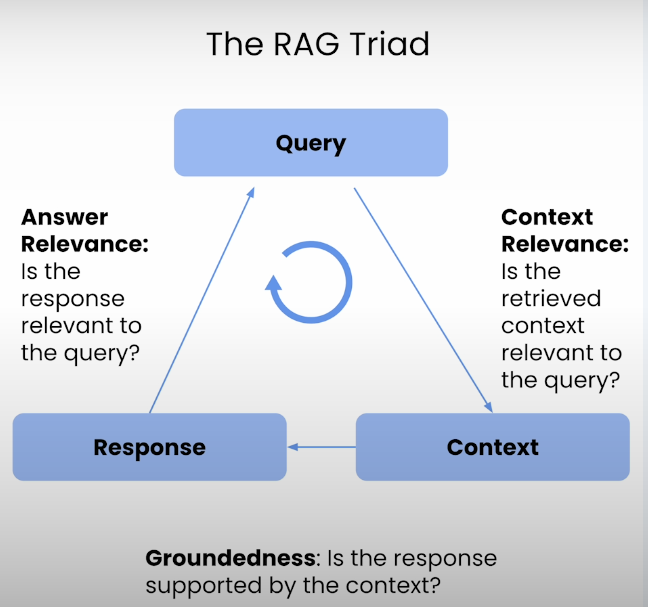

I'm using a set of questions that I have written regarding my thesis.
Questions: eval_questions.txt


In [ ]:
eval_questions = []
with open('eval_questions.txt', 'r') as file:
    for line in file:
        item = line.strip()
        print(item)
        eval_questions.append(item)
        

What are the parameter efficient finetuning techniques used in this study?
How does the learning rate affect model training?
How is the dataset created?
How long are the training, validation, and test sets?


In [ ]:
print(eval_questions)

['What are the parameter efficient finetuning techniques used in this study?', 'How does the learning rate affect model training?', 'How is the dataset created?', 'How long are the training, validation, and test sets?']


In [ ]:
from trulens_eval import Tru

tru = Tru()

tru.reset_database()

c:\Users\sprin\Desktop\Thendral\DeepLearningAI\Building-and-Evaluating-Advaanced-RAG\learn-dlai-env\lib\site-packages\munch\__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-09 23:51:06,611 - WARNING - Package trulens-providers-google not present in requirements.
C:\Users\sprin\AppData\Local\Temp\ipykernel_2612\4010694121.py:1: DeprecationWarning: The `trulens_eval` module is deprecated. See https://www.trulens.org/component_guides/other/trulens_eval_migration/ for instructions on migrating to `trulens.*` modules.
  from trulens_eval import Tru
2025-12-09 23:51:07,265 - INFO - Context impl SQLiteImpl.
2025-12-09 23:51:07,266 - INFO - Will assume non-transactional DDL.


🦑 Initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


✅ experimental otel_tracing enabled.
🔒 experimental otel_tracing is enabled and cannot be changed.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


In [ ]:
import utils

from utils import get_prebuilt_trulens_recorder

tru_recorder = get_prebuilt_trulens_recorder(query_engine, app_id = 'Direct Query Engine')

In [ ]:
with tru_recorder as recording:
    for question in eval_questions:
        response = query_engine.query(question)
        

In [ ]:
records, feedback = tru.get_records_and_feedback(App_ids=[])


In [ ]:
records.head()

In [ ]:
# launches on http://localhost:8501/

tru.run_dashboard()

# Advanced RAG Pipelines

## 1. Sentence Window Retrieval

solves the Goldilocks Problem of data chunking - small chunks are good for searching but big chunks are better for understanding.

In standard setup, text embedding for searching and the text retrieved for the answer are the same.

In SWR,

* Ingestion - breaking document into small units (sentences)
* Window storage - for every sentence, a window of context (3 sentences before and after) is stored as invisible metadata
* Search - search only against the single sentences. This ensures extremely high precision (semantic similarity).
* Expansion - once best matching sentence is found, the system swaps it out for the larger window before sending it to the LLM. LLM gets a rich paragraph of context, but search mechanism has finer precision of finding specific sentence.





In [ ]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model = "gpt-3.5-turbo", temperature = 0.1)


In [ ]:
from utils import build_sentence_window_index

sentence_index = build_sentence_window_index(
    document,
    llm,
    embed_model = 'local:BAAI/bge-small-en-v1.5',
    save_dir='sentence_idx'
)

In [ ]:
from utils import get_sentence_window_query_engine

sentence_window_engine = get_sentence_window_query_engine(sentence_index)

In [ ]:
window_response = sentence_window_engine.query(
    "What are the general-purpose ASR models evaluated in this study"
)

print(str(window_response))

In [ ]:
tru.reset_database()

tru_recorder_sentence_window = get_prebuilt_trulens_recorder(
    sentence_window_engine,
    app_id = "Sentence Window Query Engine"
)

In [ ]:
for question in eval_questions:
    with tru_recorder_sentence_window as recording:
        response = sentence_window_engine.query(question)
        print(question)
        print(str(response))
        